# A Symbolic Interpreter and Correctness of Symbolic Transitions

Executing a program with the concrete minipy interpreter updates the passed environment, and potentially raises an exception. Symbolic execution, in contrast, takes into account all feasible paths through a program. We distinguish between *online* and *offline* SE (see, e.g., {cite}`baldoni.coppa.ea-18`). Online SE executes multiple symbolic paths simultaneously: For example, executing an `if` statement leads to two paths which are both explored. Offline SE reasons about one single path at a time. *Concolic execution*, where SE is guided by a single *concrete* input, is an example of the latter class. In this section, we regard *online* SE. Symbolically executing a program in an online symbolic interpreter results in multiple output environments. Also, such an interpreter cannot simply raise an exception, as this would result in a premature termination of the analysis, skipping other feasible program paths. The consequences for our static, online symbolic interpreter are:

* Instead of updating the initial symbolic environment, the interpreter produces potentially multiple new environments. Our interpreter even outputs all *intermediate* states, such that the output is a *Symbolic Execution Tree* (SET).
* Thrown exceptions are stored in the symbolic environment instead of being raise. Thus, we need another field in our `SymbolicEnvironment` class.

We implement these changes subsequently. Afterward, we show how to implement a static, online symbolic interpreter for minipy, and introduce the correctness properties *exhaustiveness* and *precision* for symbolic execution. Finally, we show how these definitions can be used to *automatically test* the symbolic interpreter. Using this methodology, we discovered two bugs of precious versions of our implementation, one of which is related to a subtle difference in the division semantics in z3 and Python.

## Symbolic Execution Trees

We first update the implementation of `SymbolicEnvironment` to include abrupt completion information:

In [1]:
import utils
from minipy import *
from semantics import *

In [2]:
class SymbolicEnvironment(SymbolicEnvironment):
    def __init__(self,
                 store: Optional[SymbolicStore] = None,
                 path_constraints: Optional[Set[z3.BoolRef]] = None,
                 abrupt_completion: Optional[Exception] = None,
                 functions: Optional[Dict[str, Tuple[Tuple[Variable], Type, Callable]]] = None):
        super().__init__(store, path_constraints, functions)
        self.abrupt_completion = abrupt_completion

    def copy(self):
        return SymbolicEnvironment(self.store, self.path_constraints, self.abrupt_completion, self.functions)

    def set(self, variable: Variable, value: SymbolicValueType) -> 'SymbolicEnvironment':
        return SymbolicEnvironment(self.store.set(variable, value), self.path_constraints,
                                   self.abrupt_completion, self.functions)

    def set_abrupt_completion(self, exc: Optional[Exception]) -> 'SymbolicEnvironment':
        return SymbolicEnvironment(self.store, self.path_constraints, exc, self.functions)

    def add_constraint(self, constraint: z3.BoolRef) -> 'SymbolicEnvironment':
        new_constraint = self.store.apply_to(constraint)
        old_constraints = {constraint for constraint in self.path_constraints
                           if not implies(new_constraint, constraint)}
        return SymbolicEnvironment(self.store,
                                   old_constraints | {new_constraint},
                                   self.abrupt_completion, self.functions)

    def add_function(self, name: str, params: Tuple[Variable], type: Type, impl: Callable) -> 'SymbolicEnvironment':
        new_functions = copy.deepcopy(self.functions)
        new_functions[name] = (params, type, impl)
        return SymbolicEnvironment(self.store, self.path_constraints, self.abrupt_completion, new_functions)

    def __str__(self):
        return ("(" +
                ("{}" if not self.path_constraints else str(self.path_constraints)) + ", " +
                str(self.store) +
                ("" if self.abrupt_completion is None else repr(self.abrupt_completion)) +
                ")")

    def to_html(self):
        prev_html = z3.in_html_mode()
        z3.set_html_mode(True)

        path_constraint_string = "{"
        if self.path_constraints:
            path_constraint_string += ", ".join(map(z3_html_escape, map(z3.obj_to_string, self.path_constraints)))
        path_constraint_string += "}"

        path_constraint_string = path_constraint_string.replace("\n", "<BR/>").replace(" ", "&nbsp;")

        result = f"({path_constraint_string}, "
        if self.abrupt_completion:
            result += f"{repr(self.abrupt_completion)}, "
        result += f"{self.store.to_html()})"

        z3.set_html_mode(prev_html)
        return result

    def __repr__(self):
        result = f"SymbolicEnvironment({repr(self.store)}, " \
                 f"{repr(self.path_constraints)}, " \
                 f"{repr(self.abrupt_completion)}, "
        result += repr({f_name: f"fun {f_name}{params} -> "
                                f"{type}" for f_name, (params, type, _) in self.functions.items()})
        return f"{result})"

    def __eq__(self, other):
        return isinstance(other, SymbolicEnvironment) and self.store == other.store and \
               self.path_constraints == other.path_constraints and \
               self.functions == other.functions and \
               (self.abrupt_completion == other.abrupt_completion is None or
                ExceptionWrapper(self.abrupt_completion) == ExceptionWrapper(other.abrupt_completion))


Next, we define a class for nodes in an SET. An SET node comprises a symbolic environment and a string representation of the next instruction to execute. We also define a `to_html` method to produce pretty output.

In [3]:
class SETNode:
    def __init__(self, environment: SymbolicEnvironment, pc: Optional[Union[ParseTree, str]] = None):
        self.environment = environment
        self.pc = pc

    @property
    def pc(self):
        return self.__pc

    @pc.setter
    def pc(self, pc: Optional[Union[ParseTree, str]]):
        if pc is None:
            self.__pc = ""
        elif type(pc) is str:
            self.__pc = pc
        else:
            assert type(pc) is tuple
            self.__pc = "" if pc is None else tree_to_string(pc).split("\n")[0].strip()

    def to_html(self):
        prev_html = z3.in_html_mode()
        z3.set_html_mode(True)

        result = f'<TABLE BORDER="0"><TR>'
        if "<BR/>" in self.environment.to_html():
            result += f'<TD BALIGN="LEFT" ALIGN="LEFT">{self.environment.to_html()}</TD>'
        else:
            result += f'<TD>{self.environment.to_html()}</TD>'
        result += "</TR>"

        if self.pc:
            result += '<TR><TD ALIGN="CENTER"><FONT FACE="Courier">' + z3_html_escape(self.pc) + "</FONT></TD></TR>"
        result += "</TABLE>"

        z3.set_html_mode(prev_html)
        return result

    def __repr__(self):
        return f"SETNode({repr(self.environment)}, {repr(self.pc)})"

    def __eq__(self, other):
        return type(other) is type(self) and self.environment == other.environment and self.pc == other.pc

Symbolic execution trees themselves are defined just like derivation trees, only with `SETNode`s instead of strings as nodes.

In [4]:
SET = Tuple[SETNode, List['SET']]

The following function produces graphical representations (using GraphViz) of SETs.

In [5]:
from graphviz import Digraph

In [6]:
def display_set(symbolic_execution_tree: SET) -> Digraph:
    def traverse_tree(dot: Digraph, tree: SET, node_id=0):
        node, children = tree
        dot.node(repr(node_id), "<" + node.to_html() + ">")

        if children:
            for child in children:
                nonlocal counter
                counter += 1
                child_id = counter
                dot.edge(repr(node_id), repr(child_id))
                traverse_tree(dot, child, child_id)

    counter = 0
    dot = Digraph(comment="Symbolic Execution Tree")
    dot.attr('node', shape='box')
    traverse_tree(dot, symbolic_execution_tree)
    return dot

Recall our small example from the previous section:

In [7]:
x = 0
y = 0

In [8]:
x = 2 * y
if x < 0:
    x = -x

The final SET resulting from symbolically executing this program will contain two leaves, one branch each for the case where the condition of the `if` statements hold or does not hold, respectively. Apart from the root, it also contains two inner nodes corresponding to the first assignment and the `if` statement. In the absence of an implemented symbolic interpreter, we manually construct this SET:

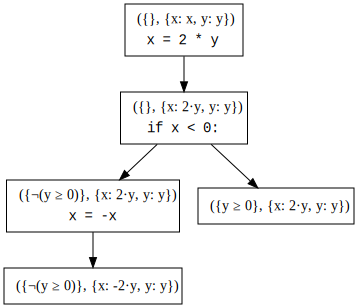

In [9]:
x = Variable("x", INT_TYPE)
y = Variable("y", INT_TYPE)

env_0 = SymbolicEnvironment(SymbolicStore({x: x.to_z3(), y: y.to_z3()}))
env_1 = env_0.set(x, z3.IntVal(2) * y.to_z3())
env_2 = env_1.add_constraint(x.to_z3() < z3.IntVal(0))
env_2_1 = env_2.set(x, z3.IntVal(-1) * x.to_z3())
env_3 = env_1.add_constraint(z3.Not(x.to_z3() < z3.IntVal(0)))

root = SETNode(env_0, "x = 2 * y")
if_node = SETNode(env_1, "if x < 0:")
inversion_node = SETNode(env_2, "x = -x")
leave_1 = SETNode(env_2_1)
leave_2 = SETNode(env_3)

tree = (root, [
    (if_node, [
        (inversion_node, [(leave_1, [])]),
        (leave_2, [])])])

display_set(tree)

## Evaluating Expressions

Also the symbolic evaluation of expressions can have multiple results. Consider the expression `y // x`: Depending on whether `x` is zero or non-zero, evaluating this expression results in a value or a `ZeroDivisionError`. Thus, our result type for expression evaluation is a collection of pairs of either a value or an exception, together with a boolean constraint signaling under which condition the respective result is returned.

In [10]:
EvalExprResult = List[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]]

We define a helper function `handle_binary_operation` computing all conditioned results for a binary operation (e.g., division or conjunction) applied on two evaluation results.

In [11]:
def handle_binary_operation(left: EvalExprResult, right: EvalExprResult, op: str) -> EvalExprResult:
    result = []

    for left_result in left:
        left_val, left_constr = left_result

        if isinstance(left_val, Exception):
            result.append(left_result)
            continue

        if op == "and":
            result.append((z3.BoolVal(False), z3.And(left_constr, z3.Not(left_val))))
        if op == "or":
            result.append((z3.BoolVal(True), z3.And(left_constr, left_val)))

        for right_result in right:
            right_val, right_constr = right_result
            constraint_conjunction = z3.And(left_constr, right_constr)
            constraint_conjunction = z3_and(*simplify_formulas(constraint_conjunction))

            if z3.is_false(constraint_conjunction):
                continue

            if isinstance(right_val, Exception):
                # Short-circuit evaluation:
                if op == "or":
                    constraint_conjunction = z3.And(constraint_conjunction, z3.Not(left_val))
                elif op == "and":
                    constraint_conjunction = z3.And(constraint_conjunction, left_val)

                constraint_conjunction = z3_and(*simplify_formulas(constraint_conjunction))
                if not z3.is_false(constraint_conjunction):
                    result.append((right_val, constraint_conjunction))

                continue

            right_zero = right_val == z3.IntVal(0)
            right_nonzero = z3.Not(right_zero)

            left_val: Union[z3.ArithRef, z3.BoolRef]
            right_val: Union[z3.ArithRef, z3.BoolRef]

            operator_map = {
                "+": operator.add,
                "-": operator.sub,
                "*": operator.mul,
                "==": operator.eq,
                "!=": lambda a, b: z3.Not(a == b),
                "<": operator.lt,
                "<=": operator.le,
                ">": operator.gt,
                ">=": operator.ge,
                "and": lambda a, b: z3.And(a, b),
                "or": lambda a, b: z3.Or(a, b)
            }

            if op in operator_map:
                result.append((operator_map[op](left_val, right_val), constraint_conjunction))
            elif op == "//":
                result.append((z3.ToInt(z3.ToReal(left_val) / z3.ToReal(right_val)),
                               z3.And(constraint_conjunction, right_nonzero)))
                result.append((ZeroDivisionError("division by zero"),
                               z3.And(constraint_conjunction, right_zero)))
            elif op == "%":
                result.append((left_val % right_val, z3.And(constraint_conjunction, right_nonzero)))
                result.append((ZeroDivisionError("division by zero"),
                               z3.And(constraint_conjunction, right_zero)))
            else:
                assert False

    return [
        (val if isinstance(val, Exception) 
         else z3.simplify(val), z3.simplify(constraint)) 
        for val, constraint in result
    ]

In [12]:
x = Variable("x", INT_TYPE)
y = Variable("y", INT_TYPE)

result = handle_binary_operation(
    [(x.to_z3(), z3.BoolVal(True))],
    [(y.to_z3(), z3.BoolVal(True))],
    "//")

display_html(str(result))

The term produced for the division, `ToInt(ToReal(x)/ToReal(y))`, might come unexpected: Why not simply `x / y`? The reason is the semantics of Python's Integer division `//`, which is a *floor division* [^floor-division]. Essentially, Python rounds towards 0 for positive, and away from 0 for negative numbers. That is, `1 // -2` evaluates to -1, while `z3.IntVal(1) / z3.IntVal(-2)` evaluates to *0*. Since the `z3.ToInt` function rounds away from zero for negative numbers, the implementation above correctly models Python's (and minipy's) floor division semantics.

Based on this function, the implementation of expression evaluation can be handled uniformly in many cases. For example, consider the evaluation of sums and terms below:

```python
class SymbolicInterpreter:
    # ...
    
    def evaluate_sum(self, expr: Sum, environment: SymbolicEnvironment) -> EvalExprResult:
        left = self.evaluate(expr.left, environment)
        right = self.evaluate(expr.right, environment)
        return handle_binary_operation(left, right, expr.op)

    def evaluate_term(self, expr: Term, environment: SymbolicEnvironment) -> EvalExprResult:
        left = self.evaluate(expr.left, environment)
        right = self.evaluate(expr.right, environment)
        return handle_binary_operation(left, right, expr.op)
    
    # ...
```

When evaluating tuple expressions, we sequentially evaluate all tuple elements and add an exception result if one of these evaluations raises an exception. We create a z3 sequence expression for the case where all tuple elements evaluate to a value. To avoid creating the same result for equivalent evaluations (e.g., if the same exception is raised under the same condition when evaluating different tuple elements), we first collect evaluation results in a set. We wrap exceptions inside a wrapper object computing sensible hashes as Python exceptions generally do not supply a suitable hashing implementation.

```python
class SymbolicInterpreter:
    # ...
    
    def evaluate_tuple(self, expr: TupleNode, environment: SymbolicEnvironment) -> EvalExprResult:
        sub_results: List[EvalExprResult] = [self.evaluate(elem, environment) 
                                             for elem in expr.elems]
        result: OrderedSet[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]] = OrderedSet([])

        combinations: List[Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]] = \
            list(itertools.product(*sub_results))

        combination: Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]
        for combination in combinations:
            values: List[SymbolicValueType] = []
            path_constraint: z3.BoolRef = z3.BoolVal(True)
            sub_result: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]
            for sub_value, sub_constraint in combination:
                path_constraint = z3.simplify(z3.And(path_constraint, sub_constraint))
                if isinstance(sub_value, Exception):
                    result.add(wrap_exceptions((sub_value, path_constraint)))
                    break

                values.append(sub_value)

            if len(values) != len(combination):
                continue

            if len(values) == 1:
                value = values[0]
                result.add((value if isinstance(value.sort(), z3.SeqSortRef) 
                            else z3.Unit(value), path_constraint))
            elif len(values) > 1:
                result.add((z3.Concat(*[value if isinstance(value.sort(), z3.SeqSortRef) 
                                        else z3.Unit(value)
                                        for value in values]), path_constraint))

        return [unwrap_exceptions(r) for r in result]
    
    # ...
```

For evaluating tuple access (e.g., `t[x]`), we have to consider the possible exceptions that may arise: Apart form the exceptions raised by evaluating `t` and `x` (which can be non-atomic expressions), `x` might be out of range, or `t` and `x` might have the wrong sorts (i.e., not `tuple` or `int`). All this is considered in the following implementation:

```python
class SymbolicInterpreter:
    # ...
    
    def handle_tuple_access(self, tuple_result: EvalExprResult,
                            expr_result: EvalExprResult) -> EvalExprResult:
        result: EvalExprResult = []

        for atom_value, atom_constraint in tuple_result:
            if isinstance(atom_value, Exception):
                result.append((atom_value, atom_constraint))
                continue

            if not isinstance(atom_value.sort(), z3.SeqSortRef):
                result.append((TypeError(f"'{atom_value.sort()} is not subscriptable"),
                               atom_constraint))
                continue

            for expr_value, expr_constraint in expr_result:
                conjunction = z3.And(atom_constraint, expr_constraint)
                if isinstance(expr_value, Exception):
                    result.append((expr_value, conjunction))
                    continue

                if expr_value.sort() != z3.IntSort():
                    result.append((TypeError(f"list indices must be integers, not {expr_value.sort()}"),
                                   conjunction))
                    continue

                atom_value: z3.SeqRef

                length_constraint = z3.And(z3.IntVal(0) <= expr_value,
                                           expr_value < z3.Length(atom_value))

                expr = z3.simplify(atom_value[expr_value])
                if expr.decl().kind() == z3.Z3_OP_ITE and \
                        implies(z3.And(conjunction, length_constraint), expr.children()[0]):
                    expr = expr.children()[1]

                result.append((expr, z3.And(conjunction, length_constraint)))
                result.append((IndexError("tuple index out of range"),
                               z3.And(conjunction, z3.Not(length_constraint))))

        return result

    # ...
```

The execution of function definitions adds a `Callable` to the symbolic environment, which accepts an environment, a list of symbolic arguments, and returns an `EvalExprResult`. The evaluation of a function call has to consider all exceptions thrown when evaluating the arguments. Additionally, an exception is registered if an unexpected number of arguments is given. Note that we do not check argument types, which is generally not done in a dynamically typed language like Python. In minipy, however, we always have complete type information, which is why this problem could be ruled out by a static check taking place before symbolic execution.

```python
class SymbolicInterpreter:
    # ...
    
    def evaluate_fun_call(self, expr: FunctionCall, environment: SymbolicEnvironment) -> EvalExprResult:
        result: EvalExprResult = []

        f_name = expr.name
        if f_name not in environment.functions:
            raise NameError(f"name '{f_name}' is not defined")

        args_result = [self.evaluate(arg, environment) for arg in expr.args]

        combinations: List[Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]] = \
            list(itertools.product(*args_result))

        combination: Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]
        for combination in combinations:
            values: List[SymbolicValueType] = []
            path_constraint: z3.BoolRef = z3.BoolVal(True)
            sub_result: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]
            for sub_value, sub_constraint in combination:
                path_constraint = z3.simplify(z3.And(path_constraint, sub_constraint))
                if isinstance(sub_value, Exception):
                    result.append(wrap_exceptions((sub_value, path_constraint)))
                    break

                values.append(sub_value)

            if len(values) != len(combination):
                continue

            if f_name in environment.functions:
                params, ret_type, fun = environment.functions[f_name]
                if len(values) != len(params):
                    raise TypeError(
                        f"{f_name}({', '.join(map(str, params))}) takes {len(params)} "
                        f"argument(s) but {len(values)} were given")

                result.extend(fun(environment, *values))
            else:
                assert False

        return result
    
    # ...
```

## Executing Statements

Similarly to the evaluation of expressions, the execution of statements has to consider all possible outcomes, such that the execution result is a tree and not a mere update of the environment. We explain the implementation of the execution functions for the stereotypical assignment, `if`, `try`, and `while` statements.

Executing an assignment results in one leaf node per raised exception during the evaluation of the right-hand side, plus a normal evaluation result when the right-hand side evaluates to a value. 

```python
class SymbolicInterpreter:
    # ...
    
    def execute_assignment(self, stmt: Assignment, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.expression, environment)

        children: List[SET] = []
        result = (SETNode(environment, stmt.code), children)

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                children.append((
                    SETNode(environment.add_constraint(constraint)
                            .set_abrupt_completion(value), None),
                    []
                ))
            else:
                variable = Variable(stmt.lhs, get_type_for_z3_expr(value))
                children.append((
                    SETNode(environment.add_constraint(constraint)
                            .set(variable, value), None),
                    []
                ))

        return result
    
    # ...
```

In the case of an `if` statement, we have one leaf for each raised exception when evaluating the guard, plus one leaf each for the execution of the then and else branch of the conditional. To avoid creating infeasible subtrees, we add an unsatisfiability check for each case. To that end, we implement a method `unsatisfiable()` in the `SymbolicEnvironment` class:

In [13]:
class SymbolicEnvironment(SymbolicEnvironment):
    def unsatisfiable(self) -> bool:
        return is_unsat(z3_and(*[constraint for constraint in self.path_constraints]))

```python
class SymbolicInterpreter:
    # ...
    
    def execute_if_stmt(self, stmt: IfStmt, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.guard, environment)

        result: SET = (SETNode(environment, stmt.code), [])

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                exc_node = SETNode(environment.add_constraint(constraint)
                                   .set_abrupt_completion(value), '')
                if not exc_node.environment.unsatisfiable():
                    result[1].append((exc_node, []))
                continue

            assert z3.is_bool(value)

            then_constraint: z3.BoolRef = z3.simplify(value)
            then_env = environment.add_constraint(constraint).add_constraint(then_constraint)

            if not then_env.unsatisfiable():
                subtree = self.execute_block(stmt.then_block, then_env)
                result[1].append(subtree)

            else_constraint = z3.simplify(z3.Not(value))
            else_env = environment.add_constraint(constraint).add_constraint(else_constraint)

            if not else_env.unsatisfiable():
                if stmt.else_block is not None:
                    subtree = self.execute_block(stmt.else_block, else_env)
                    result[1].append(subtree)
                else:
                    result[1].append((SETNode(else_env, ''), []))

        return result
    
    # ...
```

The path condition for the then leg of the `if` statement is extended by the constraint corresponding to the evaluation of the guard along with the evaluation result of the guard expression. Including the constraint for the value of the guard is important if its evaluation can raise an exception; then, we may only execute the bodies of the `if` statement in the normal completion case.

Executing a `try` statement is relatively simple. The only specialty is that we have to look up exception types from `except` clauses to check whether a raised exception matches the caught type (alternatively, we could resort to simple class name comparisons).

```python
class SymbolicInterpreter:
    # ...
    
    def execute_try_stmt(self, stmt: TryStmt, environment: Environment) -> None:
        try:
            self.execute_block(stmt.block, environment)
        except Exception as exc:
            if issubclass(type(exc), AbruptCompletionNoException):
                raise exc

            if stmt.exc_type is not None:
                caught_exc_type = getattr(sys.modules["builtins"], stmt.exc_type)
                if issubclass(type(exc), caught_exc_type):
                    self.execute_block(stmt.except_block, environment)
                    return
            else:
                self.execute_block(stmt.except_block, environment)
                return

            assert False
    
    # ...
```

The most "problematic" statement in symbolic execution of minipy is the `while` statement. Consider the implementation of the `execute_while_stmt` method in the concrete minipy interpreter:

```python
class Interpreter:
    # ...
    
    def execute_while_stmt(self, stmt: WhileStmt, environment: Environment) -> None:
        eval_guard_res = self.evaluate(stmt.guard, environment)
        assert type(eval_guard_res) is bool

        while eval_guard_res:
            try:
                self.execute_block(stmt.body, environment)
            except Continue:
                eval_guard_res = self.evaluate(stmt.guard, environment)
                continue
            except Break:
                break
            eval_guard_res = self.evaluate(stmt.guard, environment)
        else:
            if stmt.else_block is not None:
                self.execute_block(stmt.else_block, environment)
                return

    # ...
```

The concrete interpreter evaluates the guard, executes the body if the guard evaluates to true, checks for the special `Continue` and `Break` exceptions, and continues doing this until the guard evaluates to false (or a `Continue` or `Break` was encountered). The simplest way of symbolically executing a loop is to mimic this behavior, which is called *loop unrolling* in SE terminology {cite}`ahrendt.beckert.ea-16` {cite}`baldoni.coppa.ea-18`. Implementing this is not too difficult:

```python
class SymbolicInterpreter:
    # ...
    
    def execute_while_stmt(self, stmt: WhileStmt, environment: SymbolicEnvironment) -> SET:
        eval_guard_res = self.evaluate(stmt.guard, environment)
        result = (SETNode(environment, stmt.code), [])

        for value, constraint in eval_guard_res:
            if isinstance(value, Exception):
                exc_node = SETNode(environment.add_constraint(constraint).set_abrupt_completion(value), '')
                if not exc_node.environment.unsatisfiable():
                    result[1].append((exc_node, []))
                continue

            then_constraint: z3.BoolRef = z3.simplify(value)
            then_env = environment.add_constraint(constraint).add_constraint(then_constraint)

            if not then_env.unsatisfiable():
                subtree = self.execute_block(stmt.body, then_env)
                result[1].append(subtree)
                for leaf in get_leaves(subtree):
                    node, _ = leaf
                    env = node.environment
                    exc = env.abrupt_completion
                    if exc is not None:
                        if isinstance(exc, Continue):
                            env = env.set_abrupt_completion(None)
                        elif isinstance(exc, Break):
                            env = env.set_abrupt_completion(None)
                            result = replace_in_tree(
                                result, leaf, (SETNode(env, ''), []))
                            continue
                        else:
                            continue

                    while_tree = self.execute_while_stmt(stmt, env)
                    result = replace_in_tree(result, leaf, while_tree)
                    continue

            else_constraint: z3.BoolRef = z3.simplify(z3.Not(value))
            else_env = environment.add_constraint(constraint).add_constraint(else_constraint)

            if not else_env.unsatisfiable():
                if stmt.else_block is not None:
                    subtree = self.execute_block(stmt.else_block, else_env)
                    result[1].append((SETNode(else_env, 'else:'), [subtree]))
                else:
                    result[1].append((SETNode(else_env, ''), []))

        return result

    
    # ...
```

Apart from the standard differences between the concrete and symbolic interpreter (which correspond to the differences of the respective implementations of the execution of an `if` statement), the most striking difference is that the implementation is recursive, which is a little easier to implement. Furthermore, the execution of the body can, of course, result in a tree with multiple leaves. We replace each leaf from that tree with a leaf indicating what to execute next. For instance, in the case of an encountered `Break`, we replace the leaf node with a single node without children, and reset the abrupt completion flag (`env = env.set_abrupt_completion(None)`) since the loop "catches" abrupt completion due to `break` statements. For the normal completion case, we execute the loop once again, and replace the normal completion leaves of the body with the newly generated trees resulting from the loop execution. The complete code for the symbolic interpreter, along with some helper functions, follows bellow (press the toggle on the right).

In [14]:
from typing import Any
from orderedset import OrderedSet
import itertools


SomeTree = Tuple[Any, List['SomeTree']]


def tree_contains(tree: SET, needle: SET) -> bool:
    if tree is needle:
        return True
    node, children = tree
    if not children:
        return False
    return any(tree_contains(child, needle) for child in children)


def replace_in_tree(tree: SET, to_replace: SET, new_tree: SET) -> SET:
    assert tree_contains(tree, to_replace)
    for path, subtree in path_iterator(tree):
        if subtree is to_replace:
            return replace_tree_path(tree, path, new_tree)
        
        
def replace_tree_path(in_tree: SomeTree, path: Path, replacement_tree: SomeTree) -> SomeTree:
    """In-place subtree replacement preserving identity of other subtrees."""
    if not path:
        return replacement_tree

    curr_parent = in_tree
    last_idx = path[0]
    curr_tree = curr_parent[1][last_idx]
    path = path[1:]

    while path:
        last_idx = path[0]
        path = path[1:]
        curr_parent = curr_tree
        curr_tree = curr_tree[1][last_idx]

    curr_parent[1][last_idx] = replacement_tree

    return in_tree

        
def path_iterator(tree: SomeTree, path: Path = ()) -> Generator[Tuple[Path, SomeTree], None, None]:
    yield path, tree
    if tree[1] is not None:
        for i, child in enumerate(tree[1]):
            yield from path_iterator(child, path + (i,))

        
def get_type_for_z3_expr(expr: z3.ExprRef) -> Type:
    if z3.is_int(expr):
        return INT_TYPE
    elif z3.is_seq(expr):
        return TUPLE_TYPE
    elif z3.is_bool(expr):
        return BOOL_TYPE

    assert False
    
    
def implies(premise: z3.BoolRef, conclusion: z3.BoolRef) -> bool:
    s = z3.Solver()
    s.add(z3.Not(z3.Implies(premise, conclusion)))
    return s.check() == z3.unsat
        
        
class SymbolicReturn(AbruptCompletionNoException):
    def __init__(self, value: SymbolicValueType):
        self.value = value


class SymbolicInterpreter:
    def __init__(self):
        self.stmt_interpretations: Dict[typing.Type[ASTNode], Callable[[ASTNode, SymbolicEnvironment], SET]] = {
            Stmts: self.execute_stmts,
            Pass: self.execute_pass,
            BreakNode: self.execute_break,
            ContinueNode: self.execute_continue,
            ReturnNode: self.execute_return_stmt,
            Assert: self.execute_assert_stmt,
            Assignment: self.execute_assignment,
            Block: self.execute_block,
            FunctionDef: self.execute_function_def,
            TryStmt: self.execute_try_stmt,
            WhileStmt: self.execute_while_stmt,
            IfStmt: self.execute_if_stmt,
        }

        self.expr_interpretations: Dict[typing.Type[Expression], Callable[[ASTNode, SymbolicEnvironment],
                                                                          EvalExprResult]] = {
            Disjunction: self.evaluate_disjunction,
            Conjunction: self.evaluate_conjunction,
            Inversion: self.evaluate_inversion,
            Comparison: self.evaluate_comparison,
            Sum: self.evaluate_sum,
            Term: self.evaluate_term,
            Factor: self.evaluate_factor,
            TupleNode: self.evaluate_tuple,
            TupleAccess: self.evaluate_tuple_access,
            FunctionCall: self.evaluate_fun_call,
            Param: self.evaluate_param,
            BooleanAtom: self.evaluate_boolean,
            IntAtom: self.evaluate_int,
            NameAtom: self.evaluate_name,
        }

    def execute(self, stmt: ASTNode, environment: SymbolicEnvironment) -> SET:
        t = type(stmt)
        if isinstance(stmt, WhileStmt):
            return self.execute_while_stmt(stmt, environment)

        if t in self.stmt_interpretations:
            return self.stmt_interpretations[t](stmt, environment)

        if isinstance(stmt, Expression):
            # Expression Statements
            return SETNode(environment, stmt.code), [(SETNode(environment.add_constraint(constraint), None), [])
                                                     for _, constraint in self.evaluate(stmt, environment)]

        assert False

    def execute_stmts(self, stmts: Stmts, environment: SymbolicEnvironment) -> SET:
        return self.execute_sequence(tuple(stmts.stmts), environment)

    def execute_sequence(self, stmts: Tuple[ASTNode, ...], environment: SymbolicEnvironment) -> SET:
        result = None
        leaves: List[SET] = []

        for stmt in stmts:
            if result is None:
                tree = self.execute(stmt, environment)
                result, leaves = tree, get_leaves(tree)
                continue

            for leaf in leaves:
                node, children = leaf
                if node.environment.abrupt_completion is not None:
                    continue
                tree = self.execute(stmt, node.environment)

                assert tree_contains(result, leaf)
                result = replace_in_tree(result, leaf, tree)

            leaves = get_leaves(result)

        return result

    def execute_pass(self, stmt: Pass, environment: SymbolicEnvironment) -> SET:
        return SETNode(environment, stmt.code), [(SETNode(environment, None), [])]

    def execute_break(self, stmt: BreakNode, environment: SymbolicEnvironment) -> SET:
        return SETNode(environment, stmt.code), [(SETNode(environment.set_abrupt_completion(Break()), None), [])]

    def execute_continue(self, stmt: ContinueNode, environment: SymbolicEnvironment) -> SET:
        return SETNode(environment, stmt.code), [(SETNode(environment.set_abrupt_completion(Continue()), None), [])]

    def execute_return_stmt(self, stmt: ReturnNode, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.expression, environment)

        children: List[SET] = []
        result = (SETNode(environment, stmt.code), children)

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                children.append((SETNode(environment
                                         .add_constraint(constraint)
                                         .set_abrupt_completion(value), ''), []))
            else:
                children.append((SETNode(environment
                                         .add_constraint(constraint)
                                         .set_abrupt_completion(SymbolicReturn(value)), ''), []))

        return result

    def execute_assert_stmt(self, stmt: Assert, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.expression, environment)

        children: List[SET] = []
        result = (SETNode(environment, stmt.code), children)

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                exc_node = (SETNode(environment
                                    .add_constraint(constraint)
                                    .set_abrupt_completion(value), ''), [])
                if not exc_node[0].environment.unsatisfiable():
                    children.append(exc_node)
            else:
                assert type(value) is z3.BoolRef
                sat_node = (SETNode(environment
                                    .add_constraint(constraint)
                                    .add_constraint(value), ''), [])
                if not sat_node[0].environment.unsatisfiable():
                    children.append(sat_node)
                viol_node = (SETNode(environment
                                     .add_constraint(constraint)
                                     .add_constraint(z3.Not(value))
                                     .set_abrupt_completion(AssertionError()), ''), [])
                if not viol_node[0].environment.unsatisfiable():
                    children.append(viol_node)

        return result

    def execute_assignment(self, stmt: Assignment, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.expression, environment)

        children: List[SET] = []
        result = (SETNode(environment, stmt.code), children)

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                children.append((
                    SETNode(environment.add_constraint(constraint)
                            .set_abrupt_completion(value), None),
                    []
                ))
            else:
                variable = Variable(stmt.lhs, get_type_for_z3_expr(value))
                children.append((
                    SETNode(environment.add_constraint(constraint)
                            .set(variable, value), None),
                    []
                ))

        return result

    def execute_function_def(self, stmt: FunctionDef, environment: SymbolicEnvironment) -> SET:
        f_name = stmt.name
        ret_type = get_type(stmt.t)
        params = tuple([self.evaluate_param(param) for param in stmt.params])

        def func(environment: SymbolicEnvironment, *args: SymbolicValueType) -> EvalExprResult:
            for idx, parameter in enumerate(params):
                environment = environment.set(parameter, args[idx])

            block_result = self.execute_block(stmt.block, environment)
            result: EvalExprResult = []

            for node, _ in get_leaves(block_result):
                exc = node.environment.abrupt_completion
                if exc is None:
                    raise RuntimeError("Missing return statement")

                if isinstance(exc, SymbolicReturn):
                    result.append((exc.value, z3_and(*node.environment.path_constraints)))
                else:
                    result.append((exc, z3_and(*node.environment.path_constraints)))

            return result

        return SETNode(environment, stmt.code), [
            (SETNode(environment.add_function(f_name, params, ret_type, func), ''), [])
        ]

    def evaluate_param(self, param: Param) -> Variable:
        return Variable(param.name, get_type(param.type))

    def execute_try_stmt(self, stmt: TryStmt, environment: SymbolicEnvironment) -> SET:
        tree = self.execute_block(stmt.block, environment)
        result = (SETNode(environment, stmt.code), [tree])

        for leaf in get_leaves(tree):
            node, _ = leaf
            exc = node.environment.abrupt_completion
            if exc is None or isinstance(exc, AbruptCompletionNoException):
                continue

            if stmt.exc_type is not None:
                caught_exc_type = getattr(sys.modules["builtins"], stmt.exc_type)
                if isinstance(exc, caught_exc_type):
                    catch_block_tree = self.execute_block(stmt.except_block,
                                                          node.environment.set_abrupt_completion(None))
                    result = replace_in_tree(result, leaf, catch_block_tree)
            else:
                catch_block_tree = self.execute_block(stmt.block, node.environment.set_abrupt_completion(None))
                result = replace_in_tree(result, leaf, catch_block_tree)

        return result

    def execute_if_stmt(self, stmt: IfStmt, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.guard, environment)

        result: SET = (SETNode(environment, stmt.code), [])

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                exc_node = SETNode(environment.add_constraint(constraint).set_abrupt_completion(value), '')
                if not exc_node.environment.unsatisfiable():
                    result[1].append((exc_node, []))
                continue

            assert z3.is_bool(value)

            then_constraint: z3.BoolRef = z3.simplify(value)
            then_env = environment.add_constraint(constraint).add_constraint(then_constraint)

            if not then_env.unsatisfiable():
                subtree = self.execute_block(stmt.then_block, then_env)
                result[1].append(subtree)

            else_constraint = z3.simplify(z3.Not(value))
            else_env = environment.add_constraint(constraint).add_constraint(else_constraint)

            if not else_env.unsatisfiable():
                if stmt.else_block is not None:
                    subtree = self.execute_block(stmt.else_block, else_env)
                    result[1].append(subtree)
                else:
                    result[1].append((SETNode(else_env, ''), []))

        return result

    def execute_while_stmt(self, stmt: WhileStmt, environment: SymbolicEnvironment) -> SET:
        eval_guard_res = self.evaluate(stmt.guard, environment)
        result = (SETNode(environment, stmt.code), [])

        for value, constraint in eval_guard_res:
            if isinstance(value, Exception):
                exc_node = SETNode(environment.add_constraint(constraint).set_abrupt_completion(value), '')
                if not exc_node.environment.unsatisfiable():
                    result[1].append((exc_node, []))
                continue

            then_constraint: z3.BoolRef = z3.simplify(value)
            then_env = environment.add_constraint(constraint).add_constraint(then_constraint)

            if not then_env.unsatisfiable():
                subtree = self.execute_block(stmt.body, then_env)
                result[1].append(subtree)
                for leaf in get_leaves(subtree):
                    node, _ = leaf
                    env = node.environment
                    exc = env.abrupt_completion
                    if exc is not None:
                        if isinstance(exc, Continue):
                            env = env.set_abrupt_completion(None)
                        elif isinstance(exc, Break):
                            env = env.set_abrupt_completion(None)
                            result = replace_in_tree(
                                result, leaf, (SETNode(env, ''), []))
                            continue
                        else:
                            continue

                    while_tree = self.execute_while_stmt(stmt, env)
                    result = replace_in_tree(result, leaf, while_tree)
                    continue

            else_constraint: z3.BoolRef = z3.simplify(z3.Not(value))
            else_env = environment.add_constraint(constraint).add_constraint(else_constraint)

            if not else_env.unsatisfiable():
                if stmt.else_block is not None:
                    subtree = self.execute_block(stmt.else_block, else_env)
                    result[1].append((SETNode(else_env, 'else:'), [subtree]))
                else:
                    result[1].append((SETNode(else_env, ''), []))

        return result

    def execute_block(self, stmt: Block, environment: SymbolicEnvironment) -> SET:
        return self.execute_sequence(tuple(stmt.stmts), environment)

    def evaluate(self, expr: Expression, environment: SymbolicEnvironment) -> EvalExprResult:
        t = type(expr)
        if t in self.expr_interpretations:
            return [(value if isinstance(value, Exception) else z3.simplify(value), z3.simplify(constraint))
                    for value, constraint in self.expr_interpretations[t](expr, environment)
                    if not is_unsat(constraint)]

        assert False

    def evaluate_disjunction(self, expr: Disjunction, environment: SymbolicEnvironment) -> EvalExprResult:
        sub_results: List[EvalExprResult] = [self.evaluate(sub, environment) for sub in expr.conjunctions]

        result: EvalExprResult = sub_results[0]
        for sub_result in sub_results[1:]:
            result = handle_binary_operation(result, sub_result, "or")

        return result

    def evaluate_conjunction(self, expr: Conjunction, environment: SymbolicEnvironment) -> EvalExprResult:
        sub_results: List[EvalExprResult] = [self.evaluate(sub, environment) for sub in expr.inversions]

        result: EvalExprResult = sub_results[0]
        for sub_result in sub_results[1:]:
            result = handle_binary_operation(result, sub_result, "and")

        return result

    def evaluate_inversion(self, expr: Inversion, environment: SymbolicEnvironment) -> EvalExprResult:
        sub_result = self.evaluate(expr.inversion, environment)
        return [(exc, constr) for exc, constr in sub_result if isinstance(exc, Exception)] + \
               [(z3.Not(value), constr) for value, constr in sub_result if not isinstance(value, Exception)]

    def evaluate_comparison(self, expr: Comparison, environment: SymbolicEnvironment) -> EvalExprResult:
        left = self.evaluate(expr.left, environment)
        right = self.evaluate(expr.right, environment)
        return handle_binary_operation(left, right, expr.op)

    def evaluate_sum(self, expr: Sum, environment: SymbolicEnvironment) -> EvalExprResult:
        left = self.evaluate(expr.left, environment)
        right = self.evaluate(expr.right, environment)
        return handle_binary_operation(left, right, expr.op)

    def evaluate_term(self, expr: Term, environment: SymbolicEnvironment) -> EvalExprResult:
        left = self.evaluate(expr.left, environment)
        right = self.evaluate(expr.right, environment)
        return handle_binary_operation(left, right, expr.op)

    def evaluate_factor(self, expr: Factor, environment: SymbolicEnvironment) -> EvalExprResult:
        eval_res = self.evaluate(expr.factor, environment)

        if expr.symb == "-":
            return [(result if isinstance(result, Exception) else -result, constr)
                    for result, constr in eval_res]
        else:
            return eval_res

    def evaluate_fun_call(self, expr: FunctionCall, environment: SymbolicEnvironment) -> EvalExprResult:
        result: EvalExprResult = []

        f_name = expr.name
        if f_name not in environment.functions:
            raise NameError(f"name '{f_name}' is not defined")

        args_result = [self.evaluate(arg, environment) for arg in expr.args]

        combinations: List[Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]] = \
            list(itertools.product(*args_result))

        combination: Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]
        for combination in combinations:
            values: List[SymbolicValueType] = []
            path_constraint: z3.BoolRef = z3.BoolVal(True)
            sub_result: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]
            for sub_value, sub_constraint in combination:
                path_constraint = z3.simplify(z3.And(path_constraint, sub_constraint))
                if isinstance(sub_value, Exception):
                    result.append(wrap_exceptions((sub_value, path_constraint)))
                    break

                values.append(sub_value)

            if len(values) != len(combination):
                continue

            if f_name in environment.functions:
                params, ret_type, fun = environment.functions[f_name]
                if len(values) != len(params):
                    raise TypeError(f"{f_name}({', '.join(map(str, params))}) takes {len(params)} "
                                    f"argument(s) but {len(values)} were given")

                result.extend(fun(environment, *values))
            else:
                assert False

        return result

    def evaluate_tuple_access(self, expr: TupleAccess, environment: SymbolicEnvironment) -> EvalExprResult:
        target_res = self.evaluate(expr.atom, environment)
        expr_res = self.evaluate(expr.expression, environment)
        return self.handle_tuple_access(target_res, expr_res)

    def handle_tuple_access(self, tuple_result: EvalExprResult, expr_result: EvalExprResult) -> EvalExprResult:
        result: EvalExprResult = []

        for atom_value, atom_constraint in tuple_result:
            if isinstance(atom_value, Exception):
                result.append((atom_value, atom_constraint))
                continue

            if not isinstance(atom_value.sort(), z3.SeqSortRef):
                result.append((TypeError(f"'{atom_value.sort()} is not subscriptable"),
                               atom_constraint))
                continue

            for expr_value, expr_constraint in expr_result:
                conjunction = z3.And(atom_constraint, expr_constraint)
                if isinstance(expr_value, Exception):
                    result.append((expr_value, conjunction))
                    continue

                if expr_value.sort() != z3.IntSort():
                    result.append((TypeError(f"list indices must be integers, not {expr_value.sort()}"),
                                   conjunction))
                    continue

                atom_value: z3.SeqRef

                # In Python, indices can be in the closed interval [-len ; len - 1]
                length_constraint_1 = z3.And(z3.IntVal(0) <= expr_value,
                                             expr_value < z3.Length(atom_value))  # [0 ; len - 1]
                length_constraint_2 = z3.And(z3.IntVal(0) > expr_value,
                                             expr_value >= z3.IntVal(-1) * z3.Length(atom_value))  # [-len ; -1]

                expr = z3.simplify(atom_value[expr_value])
                if expr.decl().kind() == z3.Z3_OP_ITE and \
                        implies(z3.And(conjunction, length_constraint_1), expr.children()[0]):
                    expr = expr.children()[1]

                result.append((expr, z3.And(conjunction, length_constraint_1)))

                expr = z3.simplify(atom_value[z3.Length(atom_value) + expr_value])
                if expr.decl().kind() == z3.Z3_OP_ITE and \
                        implies(z3.And(conjunction, length_constraint_2), expr.children()[0]):
                    expr = expr.children()[1]

                result.append((expr, z3.And(conjunction, length_constraint_2)))

                result.append((IndexError("tuple index out of range"),
                               z3.And(conjunction, z3.Not(length_constraint_1), z3.Not(length_constraint_2))))

        return result

    def evaluate_name(self, expr: NameAtom, environment: SymbolicEnvironment) -> EvalExprResult:
        return [(environment[expr.name], z3.BoolVal(True))]

    def evaluate_boolean(self, expr: BooleanAtom, environment: SymbolicEnvironment) -> EvalExprResult:
        return [(z3.BoolVal(expr.value), z3.BoolVal(True))]

    def evaluate_int(self, expr: IntAtom, environment: SymbolicEnvironment) -> EvalExprResult:
        return [(z3.IntVal(expr.number), z3.BoolVal(True))]

    def evaluate_tuple(self, expr: TupleNode, environment: SymbolicEnvironment) -> EvalExprResult:
        sub_results: List[EvalExprResult] = [self.evaluate(elem, environment) for elem in expr.elems]
        result: OrderedSet[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]] = OrderedSet([])

        combinations: List[Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]] = \
            list(itertools.product(*sub_results))

        combination: Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]
        for combination in combinations:
            values: List[SymbolicValueType] = []
            path_constraint: z3.BoolRef = z3.BoolVal(True)
            sub_result: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]
            for sub_value, sub_constraint in combination:
                path_constraint = z3.simplify(z3.And(path_constraint, sub_constraint))
                if isinstance(sub_value, Exception):
                    result.add(wrap_exceptions((sub_value, path_constraint)))
                    break

                values.append(sub_value)

            if len(values) != len(combination):
                continue

            if len(values) == 1:
                value = values[0]
                result.add((value if isinstance(value.sort(), z3.SeqSortRef) else z3.Unit(value), path_constraint))
            elif len(values) > 1:
                result.add((z3.Concat(*[value if isinstance(value.sort(), z3.SeqSortRef) else z3.Unit(value)
                                        for value in values]), path_constraint))

        return [unwrap_exceptions(r) for r in result]


class ExceptionWrapper(Exception):
    """Wrapper for exception objects with support for equality checks and hashing."""

    def __init__(self, exc: Exception):
        self.exc = exc

    def __hash__(self):
        return hash((type(self.exc), self.exc.args))

    def __eq__(self, other):
        return type(self.exc) is type(other.exc) and self.exc.args == other.exc.args


def wrap_exceptions(r: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]) -> \
        Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]:
    value, constraint = r
    return ExceptionWrapper(value) if isinstance(value, Exception) else value, constraint


def unwrap_exceptions(r: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]) -> \
        Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]:
    value, constraint = r
    return value.exc if isinstance(value, ExceptionWrapper) else value, constraint


def get_leaves(tree: SET) -> List[SET]:
    node, children = tree
    if not children:
        return [tree]
    else:
        return [leaf for child in children for leaf in get_leaves(child)]

Let's give it a try:

```python
x = 2 * y
if x < 0:
    x = -x
```

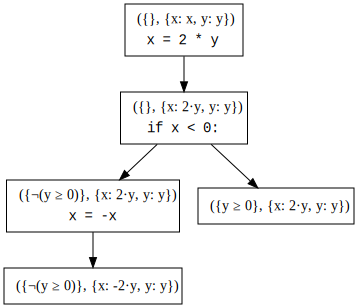

In [15]:
program = """
x = 2 * y
if x < 0:
    x = -x
"""

display_program(program)

x = Variable("x", INT_TYPE)
y = Variable("y", INT_TYPE)

env = SymbolicEnvironment(SymbolicStore({x: x.to_z3(), y: y.to_z3()}))
interpreter = SymbolicInterpreter()
tree = interpreter.execute(parse(program), env)

display_set(tree)

To try out something more complex, we revisit the linear search method from {ref}`minipy`.

In [16]:
program="""
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while i < len(haystack):
        if haystack[i] == needle:
            break
        else:
            i = i + 1
            continue
    else:
        return -1
    
    return i

t = (1, 2, 3, 4, )
r = find(x, t)
"""

display_program(program)

```python
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while i < len(haystack):
        if haystack[i] == needle:
            break
        else:
            i = i + 1
            continue
    else:
        return -1
    
    return i

t = (1, 2, 3, 4, )
r = find(x, t)
```

Instead of executing this program with a concrete "needle" value, we use a symbolic input `x`. Let's have a look at the result:

In [17]:
env = SymbolicEnvironment(SymbolicStore({x: x.to_z3()}))
interpreter = SymbolicInterpreter()

with ExpectError(print_traceback=False):
    tree = interpreter.execute(parse(program), env)
    display_set(tree)

NameError: name 'len' is not defined (expected)


Ooops... Apparently, the interpreter does not know the `len` function which is built into Python. This is not surprising: Even the concrete interpreter has to be told about existing built-in functions. For the symbolic interpreter, the situation is much more complex, since we cannot obtain call a built-in Python function with symbolic arguments. There are two ways to approach this problem:

1. Implement the `len` function in minipy and add it to our program.
2. Summarize the `len` function with a symbolic expression.

Option (2) corresponds to the concept of *function summaries* or *contracts* {cite}`ahrendt.beckert.ea-16` {cite}`baldoni.coppa.ea-18`. Such a summary is basically a conjunction of pre- and postcondition pairs, such that if a precondition holds in the current state, the postcondition can be assumed after function execution. We choose this option to teach the symbolic interpreter about the `len` function, since it would be rather impractical to add full implementations of all used library functions to each analyzed program. Furthermore, summaries are a central concept of *compositional symbolic execution* {cite}`anand.godefroid.ea-08` (see also {ref}`techniques:compositional_se`). It allows to modularly execute one piece of code at a time to derive or prove its summary, while invoking other functions by their summaries instead of executing them repeatedly.

We extend the symbolic interpreter such that we can pass it a collection of predicates that will be considered in function calls whenever a function implementation is not available. Technically, we pass the interpreter a dictionary with predicate names as keys, and triples of argument sorts, target sort, and a Callable producing a symbolic value from the given arguments as values. For the `len` function:

In [18]:
predicates = {"len": ((z3.SeqSort(z3.IntSort()),), z3.IntSort(), z3.Length)}

In [19]:
class SymbolicInterpreter(SymbolicInterpreter):
    def __init__(self,
                 predicates: Optional[Dict[str, Tuple[Tuple[z3.SortRef, ...], z3.SortRef, Callable]]] = None):
        super().__init__()
        self.predicates: Dict[str, Tuple[Tuple[z3.SortRef], z3.SortRef, Callable]] = \
            {} if predicates is None else predicates

    def evaluate_fun_call(self, expr: FunctionCall, environment: SymbolicEnvironment) -> EvalExprResult:
        result: EvalExprResult = []

        f_name = expr.name
        if f_name not in environment.functions and f_name not in self.predicates:
            raise NameError(f"name '{f_name}' is not defined")

        args_result = [self.evaluate(arg, environment) for arg in expr.args]

        combinations: List[Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]] = \
            list(itertools.product(*args_result))

        combination: Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]
        for combination in combinations:
            values: List[SymbolicValueType] = []
            path_constraint: z3.BoolRef = z3.BoolVal(True)
            sub_result: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]
            for sub_value, sub_constraint in combination:
                path_constraint = z3.simplify(z3.And(path_constraint, sub_constraint))
                if isinstance(sub_value, Exception):
                    result.append(wrap_exceptions((sub_value, path_constraint)))
                    break

                values.append(sub_value)

            if len(values) != len(combination):
                continue

            if f_name in environment.functions:
                params, ret_type, fun = environment.functions[f_name]
                if len(values) != len(params):
                    raise TypeError(f"{f_name}({', '.join(map(str, params))}) takes {len(params)} "
                                    f"argument(s) but {len(values)} were given")

                result.extend(fun(environment, *values))
            elif f_name in self.predicates:
                params_sorts, ret_sort, pred = self.predicates[f_name]
                if len(values) != len(params_sorts):
                    raise TypeError(f"{f_name}({', '.join(map(str, params_sorts))}) takes {len(params_sorts)} "
                                    f"argument(s) but {len(values)} were given")
                call_result: SymbolicValueType = pred(*values)
                assert call_result.sort() == ret_sort
                result.append((call_result, path_constraint))
            else:
                assert False

        return result

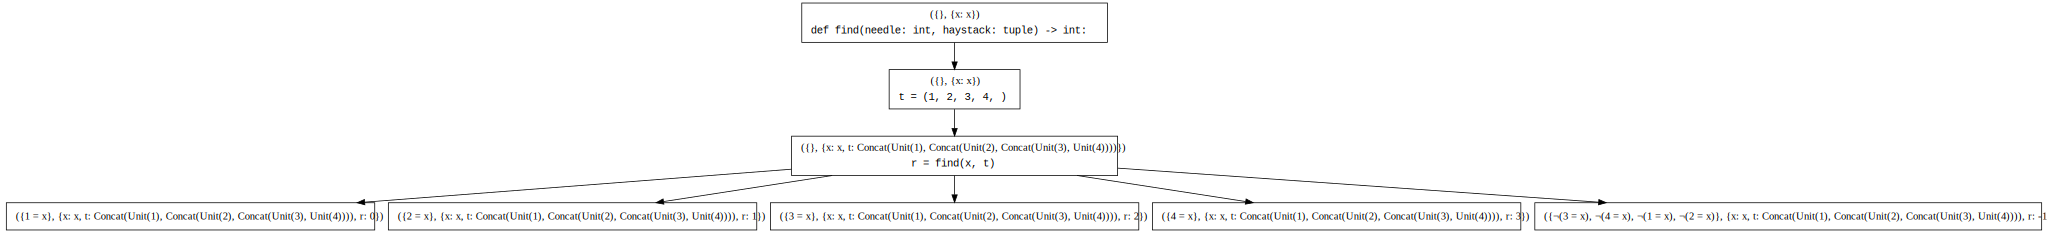

In [20]:
env = SymbolicEnvironment(SymbolicStore({x: x.to_z3()}))
interpreter = SymbolicInterpreter(predicates=predicates)

tree = interpreter.execute(parse(program), env)
display_set(tree)

Since the picture is a little oversized, here come the leaves of the tree:

In [21]:
def display_leaves(tree: SET):
    leaves = get_leaves(tree)
    for leaf, _ in leaves:
        display_html(leaf.environment.to_html())

In [22]:
display_leaves(tree)

The flat shape of the tree reveals one of the characteristics of our symbolic interpreter: Since function calls are evaluated as expressions, we do not see the SET corresponding to the execution of the function body. In {ref}`techniques:transparent_function_execution`, we describe how to transparently integrate SETs corresponding to called functions. Apart from that, the result is as expected: If `x` occurs in `t` (i.e., its value is between 1 and 4), the result value of variable `r` is `1 - x`, and -1 otherwise.

But what happens if we also leave the value of `t` symbolic? In that case, the interpreter would continue unrolling the loop until the stack overflows (we do not demonstrate this here since a timeout is hard to implement in Python). In presence of a symbolic tuple `t`, we obtain an *unbounded loop*. A straightforward to deal with such unbounded loops solution is to only unroll loops until a maximum depth. We extend the symbolic interpreter with a depth bound for loops.

In [23]:
class SymbolicInterpreter(SymbolicInterpreter):
    def __init__(self,
                 loop_unrolling_threshold: Optional[int] = None,
                 predicates: Optional[Dict[str, Tuple[Tuple[z3.SortRef, ...], z3.SortRef, Callable]]] = None):
        super().__init__(predicates)
        self.loop_unrolling_threshold = loop_unrolling_threshold
        
    def execute(self, stmt: ASTNode, environment: SymbolicEnvironment) -> SET:
        t = type(stmt)
        if isinstance(stmt, WhileStmt):
            return self.execute_while_stmt(stmt, environment, self.loop_unrolling_threshold)

        if t in self.stmt_interpretations:
            return self.stmt_interpretations[t](stmt, environment)

        if isinstance(stmt, Expression):
            # Expression Statements
            return SETNode(environment, stmt.code), [(SETNode(environment.add_constraint(constraint), None), [])
                                                     for _, constraint in self.evaluate(stmt, environment)]

        assert False

    def execute_while_stmt(self, stmt: WhileStmt, environment: SymbolicEnvironment,
                           loop_unrolling_threshold: Optional[int] = None) -> SET:
        loop_unrolling_threshold = (-1 if loop_unrolling_threshold is None
                                    else loop_unrolling_threshold)

        eval_guard_res = self.evaluate(stmt.guard, environment)
        result = (SETNode(environment, stmt.code), [])

        for value, constraint in eval_guard_res:
            if isinstance(value, Exception):
                exc_node = SETNode(environment.add_constraint(constraint).set_abrupt_completion(value), '')
                if not exc_node.environment.unsatisfiable():
                    result[1].append((exc_node, []))
                continue

            then_constraint: z3.BoolRef = z3.simplify(value)
            then_env = environment.add_constraint(constraint).add_constraint(then_constraint)

            if not then_env.unsatisfiable() and loop_unrolling_threshold != 0:
                subtree = self.execute_block(stmt.body, then_env)
                result[1].append(subtree)
                for leaf in get_leaves(subtree):
                    node, _ = leaf
                    env = node.environment
                    exc = env.abrupt_completion
                    if exc is not None:
                        if isinstance(exc, Continue):
                            env = env.set_abrupt_completion(None)
                        elif isinstance(exc, Break):
                            env = env.set_abrupt_completion(None)
                            result = replace_in_tree(
                                result, leaf, (SETNode(env, ''), []))
                            continue
                        else:
                            continue

                    while_tree = self.execute_while_stmt(stmt, env, loop_unrolling_threshold - 1)
                    result = replace_in_tree(result, leaf, while_tree)
                    continue

            else_constraint: z3.BoolRef = z3.simplify(z3.Not(value))
            else_env = environment.add_constraint(constraint).add_constraint(else_constraint)

            if not else_env.unsatisfiable():
                if stmt.else_block is not None:
                    subtree = self.execute_block(stmt.else_block, else_env)
                    result[1].append((SETNode(else_env, 'else:'), [subtree]))
                else:
                    result[1].append((SETNode(else_env, ''), []))

        return result

This time, we directly execute the body of the `find` function to obtain an SET for the actual loop:

```python
i = 0
while i < len(haystack):
    if haystack[i] == needle:
        break
    else:
        i = i + 1
        continue
else:
    return -1

return i
```

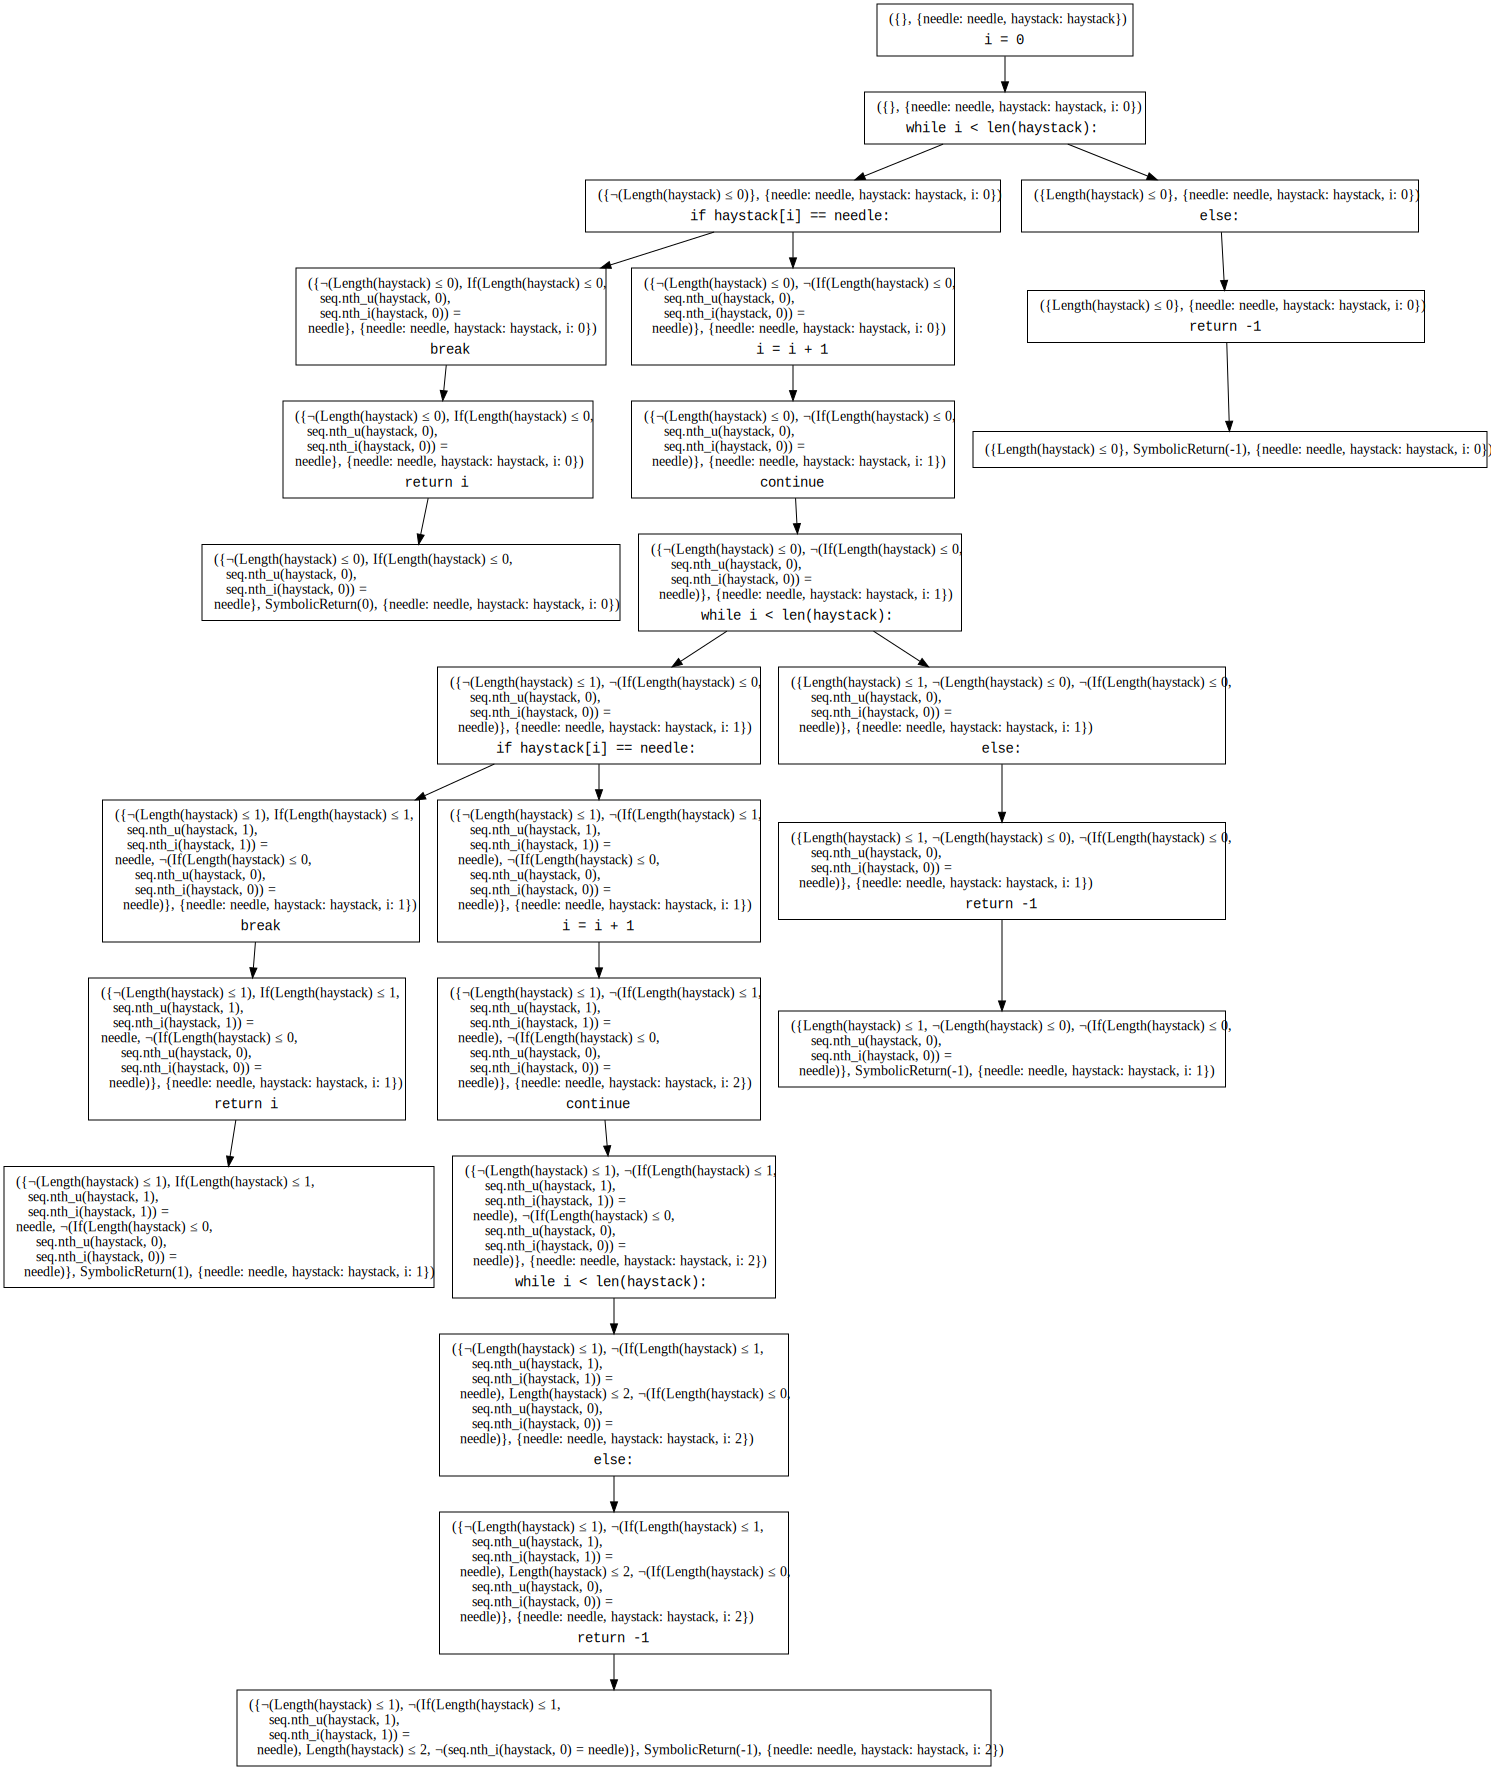

In [24]:
program="""i = 0
while i < len(haystack):
    if haystack[i] == needle:
        break
    else:
        i = i + 1
        continue
else:
    return -1

return i
"""

display_program(program)

needle = Variable("needle", INT_TYPE)
haystack = Variable("haystack", TUPLE_TYPE)

env = SymbolicEnvironment(SymbolicStore({needle: needle.to_z3(), haystack: haystack.to_z3()}))
interpreter = SymbolicInterpreter(predicates=predicates, loop_unrolling_threshold=2)
tree = interpreter.execute(parse(program), env)

display_set(tree)

In [25]:
display_leaves(tree)

For each tuple index within our set bound of 2, we obtain two leaves: One where the searched-for element has been found (the abrupt completion flag is set to `SymbolicReturn(index)`, where `index` is the first position where `needle` has been found), and one where it has not been found (`SymbolicReturn(-1)`). Additionally, we have one leaf for the case where the tuple is empty (Length(haystack) ≤ 0).

In {ref}`techniques:loops_static_se`, we introduce a technique based on *loop invariants* (summaries for loops), which allows to symbolically execute loops (in an online, static symbolic interpreter) without depth bounds.

But what does it actually mean to stop SE after a given bound has exceeded? What is the effect of choosing coarse summaries for functions or loops? And how can we check whether the implementation of the symbolic interpreter discussed in this section is correct? These questions are related to the *semantics* of symbolic transition systems, which we discuss next.

## Correctness of Symbolic Transitions

A symbolic transition relation relates symbolic inputs to symbolic outputs. Our symbolic interpreter implements a transitive closure over a transition relation consisting of 1-to-n transitions: It takes one symbolic state and produces multiple outputs, resulting in a symbolic execution tree. This leads to an exponential growth of the state space; a common problem in SE. One way to approach this problem is by merging multiple states of the tree, for example after execution of both legs of an `if` statement. Such *state merging* techniques are discussed in {ref}`techniques:state_explosion`. Merging transitions are m-to-1 transitions: Multiple states are combined into one successor. The framework from {cite}`steinhoefel-20*1`, which we present here, goes beyond that and permits m-to-n relations: An arbitrary number of input states can be combined to an arbitrary number of output states.

Formally, an SE transition relation relates a *configuration* $\mathit{Cnf}$, which is a set of symbolic states, to a pair of state sets $(I,O)$, such that $I\subseteq\mathit{Cnf}$ is replaced by $O$ in the *successor configuration*. In a standard SE system, $I$ is always a singleton; for a standard state merging transition, $O$ is a singleton. It is, however, not necessary to incorporate this restriction.

**Definition** (SE Configuration and Transition Relation). An *SE Configuration* is a set $\mathit{Cnf}\subseteq\mathit{SEStates}$. An *SE Transition Relation* is a relation $\delta\subseteq{}2^{\mathit{SEStates}}\times(2^{\mathit{SEStates}}\times2^{\mathit{SEStates}})$ associating to a configuration $\mathit{Cnf}$ transitions $t=(I,O)$ of *input states* $I\subseteq\mathit{Cnf}$ and output states $O\subseteq{}2^{\mathit{SEStates}}$. We call $\mathit{Cnf}\setminus{}I\cup{}O$ the *successor configuration* of the transition $t$ for $\mathit{Cnf}$. We write $\mathit{Cnf}\xrightarrow{t}\mathit{Cnf}'$ if $(\mathit{Cnf}, t)\in\delta$ and $\mathit{Cnf}'$ is the successor configuration of $t$ in $\mathit{Cnf}$.

Note that in this definition, the Cartesian product is not understood as associative: $\delta$ is a *binary relation*, with the power set of symbolic states as domain, and pairs of sets of states as range. Since $\delta$ is a binary relation and no partial function, there might be multiple transitions for each input configuration. This corresponds to different implementations of, e.g., loop execution: There might be a transition based on loop unrolling and one using an invariant approach. Which one to use is a choice made by an SE *strategy*.

 A *big-step SE transition relation* $\delta^\ast$ is the transitive closure of a transition relation $\delta$. In our symbolic interpreter, the `execute_...` methods for the "atomic" statement types like assignment, `if`, etc., implement a transition relation; the methods `execute_stmts` and `execute_block` realize the transitive closure.
 
Based on the previous formalizations, we can define two aspects of the correctness of symbolic transitions. Modulo some details, the literature addressing the semantics of SE {cite}`kneuper-91` {cite}`lucanu.rusu.ea-17` {cite}`boer.bonsangue-19` {cite}`steinhoefel-20*1` agrees that two aspects of SE relations are relevant: First, SE relations can be *underapproximating* because they prune the search space; and second, they can be *overapproximating* because they use coarse abstractions, e.g., for loop and function summaries. In an underapproximation setting, all concrete transitions resulting from concretizing the symbolic ones are *feasible*, which means, e.g., that any bug discovered by symbolic execution corresponds to a real bug that can be triggered by an input. We call this property *precision*. When overapproximating, it is possible that discovered bugs are not feasible. However, one cane be sure that *if* there is a feasible bug, it will be discovered. We call this property of SE relations *exhaustiveness*. An SE relation cannot be exhaustive *and* precise *in general*; however, the execution of programs without loops or recursive calls generally satisfies both property. Furthermore, summarizing loops or methods with the *strongest possible summary* leads to a precise and exhaustive execution. Notwithstanding, finding such a summary can be arbitrarily difficult.

We formally define exhaustive and precise SE transition relations, again following {cite}`steinhoefel-20*1`.

**Definition** (Exhaustive SE Transition Relations). An SE transition relation $\delta\subseteq{}2^{\mathit{SEStates}}\times(2^{\mathit{SEStates}}\times2^{\mathit{SEStates}})$ is called *exhaustive* if, and only if, for each transition $(I, O)$ in the range of $\delta$, $i\in{}I$ and concrete states $\sigma,\sigma'\in\mathit{ConcrStates}$, it holds that $\sigma'\in\mathit{concr}(i,\sigma)$ implies that there is a symbolic state $o\in{}O$ such that $\sigma'\in\mathit{concr}(o,\sigma)$.[^same-init-state]

**Definition** (Precise SE Transition Relations). An SE transition relation $\delta\subseteq{}2^{\mathit{SEStates}}\times(2^{\mathit{SEStates}}\times2^{\mathit{SEStates}})$ is called *precise* if, and only if, for each transition $(I, O)$ in the range of $\delta$, $o\in{}O$ and concrete states $\sigma,\sigma'\in\mathit{ConcrStates}$, it holds that $\sigma'\in\mathit{concr}(o,\sigma)$ implies that there is a symbolic state $i\in{}I$ such that $\sigma'\in\mathit{concr}(i,\sigma)$.

Lemma 3.1 from {cite}`steinhoefel-20*1` asserts that the exhaustiveness / precision of a big-step SE transition relation follows from the exhaustiveness / precision of the underlying single-top transition relation.

Whether we can use an SE system for a specific application scenario, most prominently testing vs. program proving, depends on whether it satisfies the right correctness property. In either case, we want to check whether a program satisfies some property or assertion $\varphi$. Before explaining how the respective properties relate to these application scenarios, we formalize what it means for a symbolic state to satisfy a property. Intuitively, a symbolic state satisfies a property if it holds in all concretizations.

**Definition** (Evaluation of Properties in SESs). Let $s=(\mathit{Constraint},\mathit{Store},\mathit{PC})$ be a symbolic state and $\varphi$ be an assertion (some formula over program variables in $\mathit{PC}$). Then, $\varphi$ does hold in $s$ if, and only if, $\sigma'\in\mathit{concr}(s,\sigma)$ implies that $\varphi$ holds in $\sigma'$, for all $\sigma,\sigma'\in\mathit{ConcrStates}$.

Practically, this definition is useful to check if a formula is violated. Since it is infeasible to examine all concretizations, it is less useful for *proving* that a symbolic state satisfies a property.

Consider the following program which is supposed to invert negative numbers:

In [26]:
x = 0

In [27]:
if x > 1:
    pass
else:
    x = -x

The condition of the `if` statement contains an off-by-one error: It should be `>=` and not `>`. We write a function for applying stores to properties, which we need to use the above definition:

In [28]:
def apply_store(store: Store, formula: z3.BoolRef) -> z3.BoolRef:
    return subst(formula, {var.to_z3(): python_expr_to_z3_expr(value)
                           for var, value in store.env.items()})

We test the property $x\geq{}0$ for a symbolic state with empty store and path condition and the above program as program counter:

In [29]:
x = Variable("x", INT_TYPE)
state = SymbolicEnvironment(SymbolicStore({x: x.to_z3()}))
pc = """
if x > 1:
    pass
else:
    x = -x
"""

x_is_positive = x.to_z3() >= z3.IntVal(0)

for _ in range(100):
    sigma = Store({x: random.randint(-10, 10)})
    sigma_prime = concr(state, pc, sigma)
    satisfies = z3.simplify(apply_store(sigma_prime, x_is_positive))
    if not satisfies:
        print(f"Postcondition {x_is_positive} not satisfied for input x == {sigma['x']}")
        break

Postcondition 0 <= x not satisfied for input x == 1


The code above only finds the bug so quickly since we restricted the range for random inputs to the interval $[-10;10]$. For the still relatively small interval $[-100;100]$, the probability of hitting 1 is already only $201^{-1}\approx{}0.5\%$. For symbolic states with empty program counter $\mathit{PC}$, however, we do *not* have to check all concretizations, and instead create a symbolic assertion that we can pass to z3. The idea is to evaluate the formula $\mathit{Constraint}\rightarrow\{\mathit{Store}\}\varphi$, where $\mathit{Store}\}\varphi$ (the application of $\mathit{Store}$ to $\varphi$) is the formula resulting from replacing all occurrences of left-hand side from $\mathit{Store}$ in $\varphi$ by their right-hand sides in $\mathit{Store}$.

Let us consider the symbolic state arising from the the execution of the inversion in the `else` branch of the `if` statement.

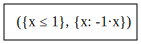

In [30]:
interpreter = SymbolicInterpreter()
tree = interpreter.execute(parse(pc), state)
leaf = get_leaves(tree)[1]
display_set(leaf)

In [31]:
proof_goal = z3.Implies(z3_and(*leaf[0].environment.path_constraints),
                       state.store.apply_to(x_is_positive))
proof_goal

Implies(x <= 1, 0 <= x)

In [32]:
z3.prove(proof_goal)

counterexample
[x = -1]


This indicates how symbolic execution is used in program proving: We execute the full program until we get a set of leaves with empty program counters, and then follow the procedure we just have demonstrated to prove that the desired property holds in those leaves.

To ensure that this leads to valid proofs, the SE transition relation used to obtain the leaves has to be *exhaustive*, as asserted by the below lemma from {cite}`steinhoefel-20*1`:[^simplified-strongly]

**Lemma** (A Property Proven by Exhaustive SE Holds for the Inputs). Let $\delta$ be an exhaustive SE transition relation and $\mathit{Cnf}\xrightarrow{(I,O)}_{\delta^\ast}\mathit{Cnf}'$. If a postcondition $\varphi$ holds for all states $o\in\mathit{Cnf}'$, it follows that $\varphi$ also holds for all $i\in\mathit{Cnf}$.

Intuitively, an exhaustive transition relation does not lose information (in the sense of represented concretizations) along the way, which means that everything we can prove for its outputs must hold for the inputs. Conversely, a violation discovered for an output cannot necessarily be transferred to an input: Discovered bugs might be infeasible for exhaustive SE systems. If feasibility of discovered bugs is a desired goal, symbolic transitions must be *precise*, i.e., not increase the set of represented concretizations during execution.

**Lemma** (A Bug Discovered by Precise SE is Feasible). Let $\delta$ be an precise SE transition relation and $\mathit{Cnf}\xrightarrow{(I,O)}_{\delta^\ast}\mathit{Cnf}'$. If a postcondition $\varphi$ is not true for some state $o\in\mathit{Cnf}'$, it follows that there is an input $i\in\mathit{Cnf}$ such that $\varphi$ does not hold in $i$.

Consequently, symbolic execution must be *precise* if we use if, e.g., in automated testing (fuzzing), and *exhaustive* if we use if for program proving.

Interestingly, the two notions of precision and exhaustiveness can be used as oracles to test the symbolic interpreter! This is, in fact, a new contribution, as we do not know of any existing work on automated testing of symbolic execution engines. To test the interpreter for exhaustiveness, for example, we take an empty symbolic and a random initial concrete state as well as a test program (the program counter), and check that some symbolic output has the same concretization. The precision check is symmetric: We assert that all concretizations for all outputs already exist in the input. Theoretically, we could create not only concrete initial states, but also test programs randomly. However, automatically generating meaningful programs is hard, which is why we use hand-crafted inputs here.

In [33]:
def concr(ses: SymbolicEnvironment,
          pc: Optional[Union[str, ASTNode]],
          sigma: Store) -> Optional[Tuple[Store, Optional[Exception]]]:
    if type(pc) is str:
        pc = parse(pc)

    sigma_1 = ses.concretize(sigma)
    if sigma_1 is None:
        return None

    if pc is None:
        return sigma_1, None

    interpreter = Interpreter()
    environment = Environment(sigma_1)

    exc = None

    try:
        interpreter.execute(pc, environment)
    except Exception as e:
        exc = e

    sigma_2 = environment.store

    return sigma_2, exc

In [34]:
def check_exhaustiveness(interpreter: SymbolicInterpreter,
                         ast_node: ASTNode,
                         input_state: SymbolicEnvironment,
                         sigma: Store) -> bool:
    concr_result_1 = concr(input_state, ast_node, sigma)
    if concr_result_1 is None:
        return True

    sigma_prime, maybe_exc = concr_result_1
    output_states = [node.environment for node, _ in get_leaves(interpreter.execute(ast_node, input_state))]

    for output_state in output_states:
        concr_result_2 = concr(output_state, None, sigma)
        if concr_result_2 is None:
            continue

        sigma_prime_prime, _ = concr_result_2

        if (sigma_prime_prime == sigma_prime and
                (maybe_exc is None or
                 ExceptionWrapper(maybe_exc) ==
                 ExceptionWrapper(output_state.abrupt_completion))):
            return True

    return False

In [1]:
def check_precision(interpreter: SymbolicInterpreter,
                    ast_node: ASTNode,
                    input_state: SymbolicEnvironment,
                    sigma: Store) -> bool:
    output_states = [node.environment for node, _ in get_leaves(interpreter.execute(ast_node, input_state))]

    concr_results_1 = [(output_state, concr_result_1)
                       for output_state, concr_result_1 in [(output_state, concr(output_state, None, sigma))
                                                            for output_state in output_states]
                       if concr_result_1 is not None]
    concr_result_2 = concr(input_state, ast_node, sigma)

    if concr_results_1 and not concr_result_2:
        return False

    for output_state, concr_result_1 in concr_results_1:
        sigma_prime, maybe_exc = concr_result_1
        sigma_prime_prime, _ = concr_result_2

        if (sigma_prime_prime != sigma_prime or
                (maybe_exc is not None and
                 ExceptionWrapper(maybe_exc) !=
                 ExceptionWrapper(output_state.abrupt_completion))):
            return False

    return True

NameError: name 'SymbolicInterpreter' is not defined

We specialized these checks to transitions with one input and multiple outputs, and also check for equal exceptions if an exception has been raised. Since we implement an automated testing procedure, we can only show the presence of bugs or that a transition is correct with some probability if no problem could be found. The functions `is_probably_exhaustive` and `is_probably_precise` return `None` if not problem with exhaustiveness / precision has been found, and otherwise a concrete store as *counterexample* for an initial assignment for a run where symbolic execution is not exhaustive or not precise.

In [36]:
def is_probably_exhaustive(interpreter: SymbolicInterpreter,
                           variables: Set[Variable],
                           ast_node: ASTNode,
                           num_runs: int = 10,
                           log: bool = False) -> Optional[Store]:
    return is_probably_correct(interpreter, variables, ast_node, True, num_runs, log)


def is_probably_precise(interpreter: SymbolicInterpreter,
                        variables: Set[Variable],
                        ast_node: ASTNode,
                        num_runs: int = 10,
                        log: bool = False) -> Optional[Store]:
    return is_probably_correct(interpreter, variables, ast_node, False, num_runs, log)


def is_probably_correct(interpreter: SymbolicInterpreter,
                        variables: Set[Variable],
                        ast_node: ASTNode,
                        exhaustiveness: bool = True,
                        num_runs: int = 10,
                        log: bool = False) -> Optional[Store]:
    symb_env: Dict[Variable, SymbolicValueType] = {
        variable: variable.to_z3()
        for variable in variables
    }
        
    input_state = SymbolicEnvironment(SymbolicStore(symb_env))
        
    for _ in range(num_runs):
        concr_env: Dict[Variable, Union[int, bool, tuple]] = {
            variable: random_val(variable.type)
            for variable in variables
        }

        sigma = Store(concr_env)

        result = (check_exhaustiveness(interpreter, ast_node, input_state, sigma) if exhaustiveness
                  else check_precision(interpreter, ast_node, input_state, sigma))
        if not result:
            if log:
                print(f"Check for initial state {concr_env}: COUNTEREXAMPLE")
            return sigma
        
        
        if log:
            print(f"Check for initial state {concr_env}: No problem discovered")

    return None


def random_val(t: Type) -> Union[int, bool, tuple]:
    if t == INT_TYPE:
        return random.randint(-100, 100)
    elif t == BOOL_TYPE:
        return random.choice([True, False])
    else:
        return tuple([random.randint(-100, 100) 
                      for _ in range(random.randint(0, 10))])

Now, we can, for example, check wether the implementation of symbolic execution of `if` statements in `SymbolicInterpreter` is precise and exhaustive. As a test program, we choose an `if` statement where the then and else branch each contain a single assignment. We choose relatively expressions for the `if` guard and assignment right-hand sides which can raise different types of exceptions.[^exc-if-found]

In [37]:
if_program = """
if a >= t[a] and g:
    x = a // c
else:
    x = c // b
"""

variables = {
    Variable("a", INT_TYPE),
    Variable("b", INT_TYPE),
    Variable("c", INT_TYPE),
    Variable("g", BOOL_TYPE),
    Variable("t", TUPLE_TYPE),
}

ast_node = parse_on(if_program, "<if_stmt>")

result = is_probably_exhaustive(SymbolicInterpreter(), variables, ast_node)
if not result:
    print("Execution of if statements is probably exhaustive.")
else:
    print(f"Execution of if statements is not exhaustive. Counterexample: {result}")

result = is_probably_precise(SymbolicInterpreter(), variables, ast_node)
if not result:
    print("Execution of if statements is probably precise.")
else:
    print(f"Execution of if statements is not precise. Counterexample: {result}")

Execution of if statements is probably exhaustive.
Execution of if statements is probably precise.


To test the symbolic execution of `while` statements, we choose a relatively simple, but unbounded loop (i.e., the evaluation of the loop guard depends on a symbolic value), and initialize the symbolic interpreter such that loops are unrolled at most two times.

In [38]:
while_program = """
while idx >= x:
    idx = idx - 1
"""

variables = {
    Variable("x", INT_TYPE),
    Variable("idx", INT_TYPE)
}


interpreter = SymbolicInterpreter(loop_unrolling_threshold=2)
ast_node = parse_on(while_program, "<while_stmt>")

result = is_probably_exhaustive(interpreter, variables, ast_node, log=True)
if not result:
    print("Execution of while statements is probably exhaustive.")
else:
    print(f"Execution of while statements is not exhaustive. Counterexample: {result}")

result = is_probably_precise(interpreter, variables, ast_node)
if not result:
    print("Execution of while statements is probably precise.")
else:
    print(f"Execution of while statements is not precise. Counterexample: {result}")

Check for initial state {Variable('x', Type('int')): -95, Variable('idx', Type('int')): 93}: COUNTEREXAMPLE
Execution of while statements is not exhaustive. Counterexample: {x: -95, idx: 93}
Execution of while statements is probably precise.


It turns out the loop unrolling is not exhaustive. This could be expected, since we prune the search space, which leads to a loss of represented concrete states; but now, we have an automatically discovered counterexample! 

In contrast to static analysis techniques like the well-known *Abstract Interpretation* {cite}`cousot.cousot-77`, which reasons in an abstract domain throughout the analysis, symbolic execution is in its nature a *precise analysis technique*. This is reflected by the relatively low effort required to come up with a precise, terminating symbolic interpreter. To render SE *exhaustive*, extra effort needs to be invested (see {ref}`techniques:loops_static_se`).

In subsequent parts of this book, we focus on individual symbolic execution *techniques*, both for exhaustive and precise SE.

## References

```{bibliography}
:filter: docname in docnames
```

[^floor-division]: See https://docs.python.org/3/reference/expressions.html#index-67

[^same-init-state]: We expressed a slightly stricter definition of exhaustiveness than the one given in {cite}`steinhoefel-20*1`. In the original definition, the concrete state $\sigma'$ may be obtained from concretizing $o$ based on a *different* initial state $\sigma''$, which allows consistently renaming variables in right-hand sides. Such a behavior is, however, quite unusual in symbolic execution, which is why we chose to simplify the definition. The same holds for the definition of precision.

[^simplified-strongly]: In {cite}`steinhoefel-20*1`, the definition is a little more involved, since it takes into account uninterpreted logic constants and functions occurring in assertions, for which a strong version of precision and exhaustiveness is required. We only consider assertions over program variables and interpreted functions (such as addition), and possibly quantified formulas with bound logic variables, which permits to simplify the definition.

[^exc-if-found]: We actually found a bug in our symbolic interpreter by testing it using the described methodology. In Python, negative array indices are admissible: `t[-i]`, for positive `i`, is equivalent to `t[len(t)-i`. The symbolic interpreter, however, reported an `IndexError` in a previous version (which is the behavior of `Java`, for instance). By reducing the reported initial state, we quickly discovered the problem. We also discovered a more subtle bug related to Python's semantics: Integer division in Python is a floor division, such that `1 // -2` yields `-1`, while z3 computes `0`. We had to model the Python behavior by replacing `left_val / right_val` by `z3.ToInt(z3.ToReal(left_val) / z3.ToReal(right_val))` in the `handle_binary_operation` method.